# Project 6: IMDb Top 250 Movies

In [1]:
from IPython.core.display import Image
from imdbpie import Imdb
import pandas as pd
import plotly as pt
from matplotlib import pyplot as plt
import numpy as np
from sklearn import cross_validation, preprocessing
from sklearn.preprocessing import MinMaxScaler
import time
import requests
import bs4
from bs4 import BeautifulSoup
import cPickle
import seaborn as sns
import re
from matplotlib import cm
from matplotlib.colors import ColorConverter
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

% matplotlib inline

In [2]:
Image(url='http://bit.ly/29OUgDA', width = 650)

In [3]:
# import statsmodels.api as st
# from sklearn import linear_model as lm
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.cross_validation import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import cross_val_predict
# from sklearn.cross_validation import cross_val_score
# import matplotlib.patheffects as path_effects

Get Top 250 movies, save to file:

In [4]:
# imdb = Imdb()
# imdb = Imdb(anonymize=True)
# imdb = Imdb(cache=True)
# top = imdb.top_250()

In [5]:
# top = pd.DataFrame(top)
# top.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/top.csv', index = False, encoding = 'utf-8')
# len(top)

Load Top 250 movie data from file:

In [6]:
top = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/top.csv')

In [7]:
top.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1680129,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149482,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,786145,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1665144,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,859879,8.9,tt0108052,Schindler's List,feature,1993


In [8]:
top.dtypes

can_rate        bool
image         object
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year           int64
dtype: object

In [9]:
top['image'][0]

"{u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg', u'width': 933, u'height': 1388}"

In [10]:
del top['image']

In [11]:
top['can_rate'].value_counts()

True    250
Name: can_rate, dtype: int64

In [12]:
del top['can_rate']

In [13]:
top['type'].value_counts()

feature    250
Name: type, dtype: int64

In [14]:
del top['type']

In [15]:
top = top[['tconst', 'title', 'rating', 'num_votes', 'year']]

In [16]:
top['year'] = top['year'].apply(lambda x: int(x))

In [17]:
top['num_votes'].describe()

count    2.500000e+02
mean     4.034077e+05
std      3.310935e+05
min      2.509900e+04
25%      1.229165e+05
50%      3.236250e+05
75%      5.948370e+05
max      1.680129e+06
Name: num_votes, dtype: float64

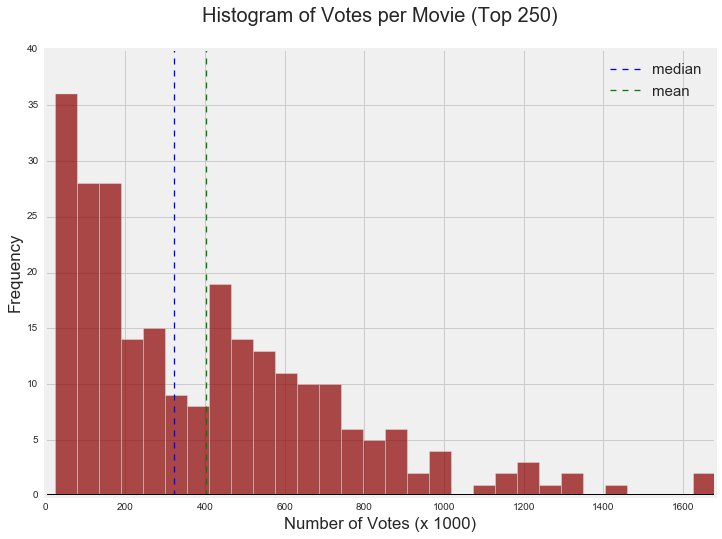

In [18]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['num_votes']/1000, color = 'darkred', bins = 30, alpha = 0.7)
plt.axvline(top['num_votes'].median()/1000, color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['num_votes'].mean()/1000, color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Votes per Movie (Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Number of Votes (x 1000)')

plt.xlim([0, max(top['num_votes']/1000)])
plt.ylim([0, 40])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

Unclear what is going on in that dip around 400,000:

In [19]:
top[(top['num_votes'] > 380000) & (top['num_votes'] < 420000)].sort('num_votes', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,tconst,title,rating,num_votes,year
33,tt0054215,Psycho,8.5,419804,1960
25,tt0118799,Life Is Beautiful,8.6,417127,1997
28,tt0245429,Spirited Away,8.6,414826,2001
135,tt0120735,"Lock, Stock and Two Smoking Barrels",8.2,412873,1998
96,tt0119488,L.A. Confidential,8.3,412255,1997
226,tt0073195,Jaws,8.0,409985,1975
213,tt1663202,The Revenant,8.1,394507,2015
44,tt2582802,Whiplash,8.5,393421,2014
32,tt0034583,Casablanca,8.6,385646,1942
228,tt1392214,Prisoners,8.1,380322,2013


Which movies have more than a million votes?

In [20]:
top[top['num_votes'] > 1000000][['title', 'year', 'num_votes']].sort('num_votes', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,num_votes
0,The Shawshank Redemption,1994,1680129
3,The Dark Knight,2008,1665144
13,Inception,2010,1458647
9,Fight Club,1999,1339026
6,Pulp Fiction,1994,1316868
12,Forrest Gump,1994,1242614
10,The Lord of the Rings: The Fellowship of the Ring,2001,1232102
17,The Matrix,1999,1210771
7,The Lord of the Rings: The Return of the King,2003,1208872
1,The Godfather,1972,1149482


In [21]:
top['rating'].describe()

count    250.000000
mean       8.315200
std        0.231133
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: rating, dtype: float64

Remember: minimum rating is so high because we're only looking at top 250 movies!

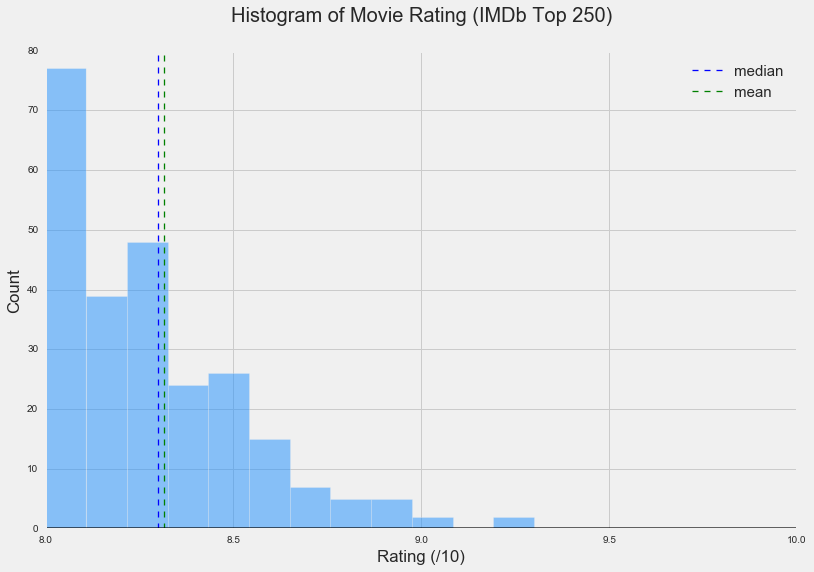

In [22]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['rating'], color = 'dodgerblue', alpha = 0.5, bins = 12)
plt.axvline(top['rating'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['rating'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('Histogram of Movie Rating (IMDb Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Rating (/10)')

plt.xlim([min(top['rating']), 10])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [23]:
top['year'].describe()

count     250.000000
mean     1984.028000
std        24.152361
min      1921.000000
25%      1964.000000
50%      1991.000000
75%      2003.750000
max      2016.000000
Name: year, dtype: float64

In the histogram below, each bar slot represents one year:

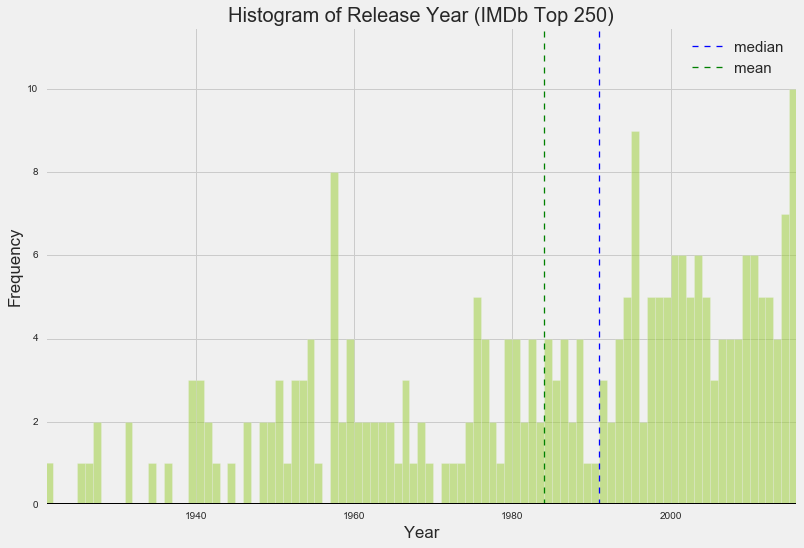

In [24]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['year'], color = 'yellowgreen', alpha = 0.5, bins = 95)
plt.axvline(top['year'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['year'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Release Year (IMDb Top 250)', fontsize = 20)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Year')

plt.xlim([min(top['year']), max(top['year'])])
plt.ylim([0, 11.5])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

1957 was a good year:

In [25]:
top[top['year'] == 1957][['title', 'year']].sort('title')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
5,12 Angry Men,1957
174,Nights of Cabiria,1957
56,Paths of Glory,1957
131,The Bridge on the River Kwai,1957
134,The Seventh Seal,1957
245,Throne of Blood,1957
140,Wild Strawberries,1957
71,Witness for the Prosecution,1957


As was 1995:

In [26]:
top[top['year'] == 1995][['title', 'year']].sort('title')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
205,Before Sunrise,1995
75,Braveheart,1995
138,Casino,1995
122,Heat,1995
227,La Haine,1995
21,Se7en,1995
24,The Usual Suspects,1995
91,Toy Story,1995
219,Twelve Monkeys,1995


The spike farthest to the right on the histogram is combined 2015 and 2016-to-date:

In [27]:
top[(top['year'] == 2015) | (top['year'] == 2016)][['title', 'year']].sort('title')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
160,Captain America: Civil War,2016
203,Deadpool,2016
118,Inside Out,2015
183,Mad Max: Fury Road,2015
123,Room,2015
180,Spotlight,2015
141,Star Wars: The Force Awakens,2015
232,The Martian,2015
213,The Revenant,2015
178,Zootopia,2016


In [28]:
top_scaled = preprocessing.scale(top[['num_votes', 'rating', 'year']])
top_scaled = pd.DataFrame(top_scaled, columns = ['num_votes', 'rating', 'year'])

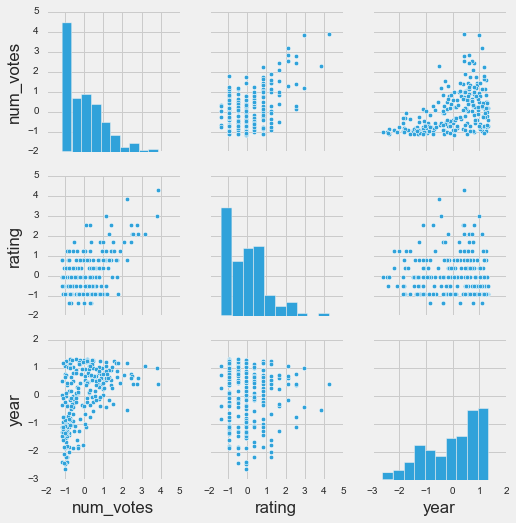

In [29]:
sns.pairplot(top_scaled)

Let's dig a little deeper into these plots...  

We'll use 'rating' to assign the area of points on a scatterplot of number of votes vs. year of movie release.  If we just try dividing by a constant, the difference in size is not readily apparent, so let's try normalizing!

In [30]:
top_scaled['rating'].describe()

count    2.500000e+02
mean     3.674838e-15
std      1.002006e+00
min     -1.366450e+00
25%     -9.329318e-01
50%     -6.589481e-02
75%      3.676237e-01
max      4.269290e+00
Name: rating, dtype: float64

The bars are going to look the same but their location on the x-axis will have changed:

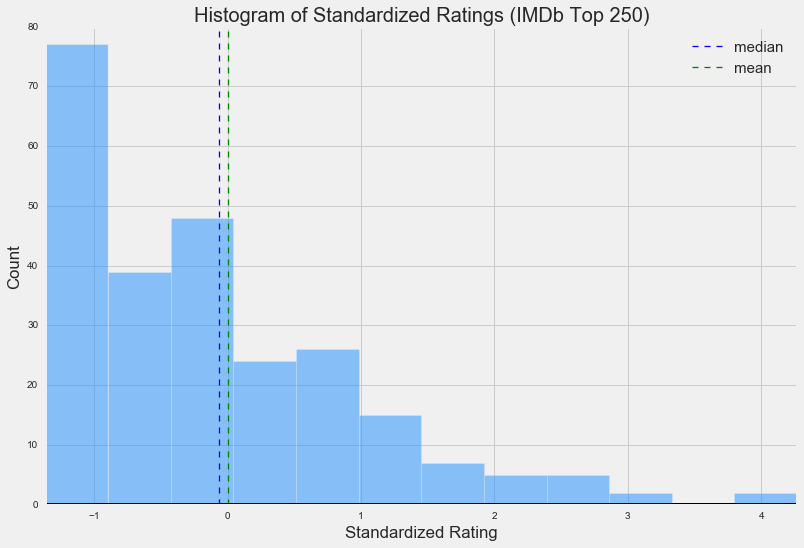

In [31]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top_scaled['rating'], color = 'dodgerblue', alpha = 0.5, bins = 12)
plt.axvline(top_scaled['rating'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top_scaled['rating'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Standardized Ratings (IMDb Top 250)', fontsize = 20)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Standardized Rating')

plt.xlim([min(top_scaled['rating']), max(top_scaled['rating'])])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

If we use the standardized ratings multiplied by a constant, though, we'll have a negative area assigned to everything under the mean!  Can't have that.  Let's add a little more than the minimum value to every standardized rating and then multiply by a constant:

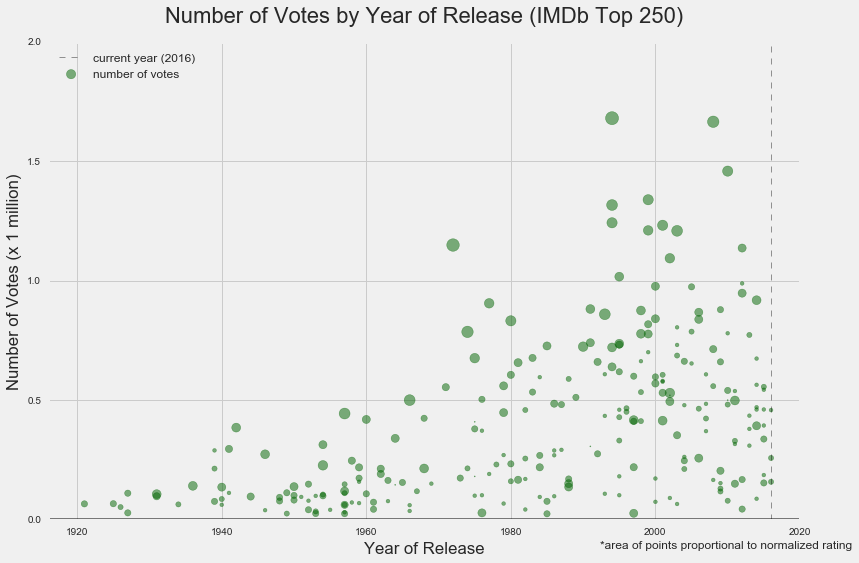

In [32]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

area = (top_scaled['rating'] + 1.4)*30

plt.scatter(top['year'], top['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'number of votes')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)
plt.axhline(0, color='black', alpha = 0.5)
plt.axvline(2016, color='black', linestyle='dashed', alpha = 0.5, linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 2.0])
plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*area of points proportional to normalized rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

In [33]:
top_scaled['year'].describe()

count    2.500000e+02
mean    -8.291146e-16
std      1.002006e+00
min     -2.614835e+00
25%     -8.308991e-01
50%      2.892465e-01
75%      8.182042e-01
max      1.326418e+00
Name: year, dtype: float64

The plot below suggests that the more votes a movie has, the higher its rating will be.  Let's scrape imdb.com to find some more variables!

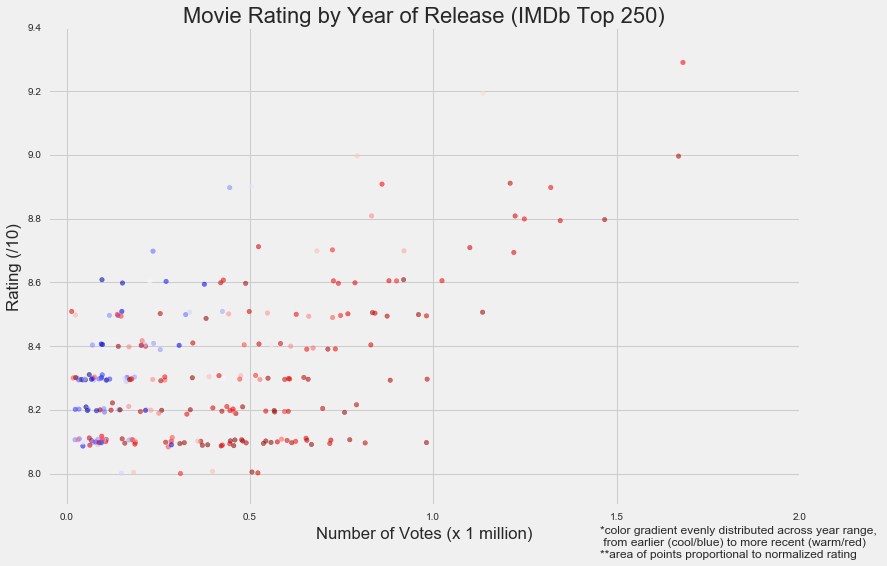

In [34]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
count = 0
for i in top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
top['top_year_color'] = top_year_color

def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, \
           verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, norm=norm, vmin=vmin, \
                       vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

jitter(top['num_votes']/1000000, top['rating'], color = top['top_year_color'], alpha = 0.55)


plt.title('Movie Rating by Year of Release (IMDb Top 250)', fontsize = 22)
plt.axhline(0, color='darkblue', alpha = 0.5)
# y label
plt.ylabel('Rating (/10)')

# x label
plt.xlabel('Number of Votes (x 1 million)')

# set the figure boundaries
plt.xlim([-0.05, 2])
plt.ylim([7.9, 9.4])
plt.grid(True)

m, b = np.polyfit(top['rating'], top['num_votes']/1000000, 1)

plt.plot(top['num_votes']/1000000, m*top['num_votes']/1000000 + b, '-', linewidth = 0.7)

plt.annotate('*color gradient evenly distributed across year range, \n from earlier (cool/blue) to more recent (warm/red)\n'\
             '**area of points proportional to normalized rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

Let's use an API to get what we can:

In [35]:
# certification = []
# for movie in top['tconst']:
#     time.sleep(0.25)
#     title = imdb.get_title_by_id(movie)
#     cert = title.certification
#     certification.append(cert)
# print 'done collecting!'
# certification = pd.DataFrame(certification)
# certification.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv', index = False, \
# encoding = 'utf-8')

In [36]:
certification = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv')
certification.columns = ['cert']
top['cert'] = certification
top['cert'].value_counts()

R            92
Not Rated    33
PG           32
PG-13        30
Approved     14
Unrated      12
G            10
TV-PG         9
TV-14         6
TV-MA         4
Passed        3
M             2
X             1
TV-G          1
E             1
Name: cert, dtype: int64

There are too many unique values!  Let's consolidate.  This cell prints all movies not having 'R', 'PG-13', 'PG', or 'G' as a certification:

In [37]:
# cert_OK = ['R', 'PG-13', 'PG', 'G']
# for i in range(len(top['cert'])):
#     if top['cert'][i] in cert_OK:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'cert']]

Let's consolidate these as much as possible.  Examine (imdb.com, wikipedia) each certification except 'R', 'PG', 'PG-13', 'G'.  We'll assume those have been categorized properly.  Update if necessary. 

In [38]:
# top['cert'][101] = 'PG-13' # Indiana Jones and the Last Crusade
# top['cert'][91] = 'G' # Toy Story
# top['cert'][78] = 'R' # A Clockwork Orange
# top['cert'][34] = 'G' # City Lights
# top['cert'][80] = 'Not Rated' # Double Indemnity
# top['cert'][215] = 'G' # Wizard of Oz 
# top['cert'][27] = 'PG-13' # Once Upon a Time in the West
# top['cert'][241] = 'R' # A Fistful of Dollars
# top['cert'][9] = 'R' # Fight Club
# top['cert'][29] = 'R' # Saving Private Ryan
# top['cert'][74] = 'R' # Reservoir Dogs
# top['cert'][96] = 'R' # L.A. Confidential
# top['cert'][30] = 'R' # American History X
# top['cert'][40] = 'R' # Terminator 2: Judgment Day
# top['cert'][52] = 'R' # Alien
# top['cert'][64] = 'PG-13' # Princess Mononoke
# top['cert'][100] = 'R' # Scarface
# top['cert'][145] = 'Not Rated' # Judgment at Nuremberg
# top['cert'][18] = 'Not Rated' # Seven Samurai
# top['cert'][26] = 'R' # Léon: The Professional
# top['cert'][59] = 'Not Rated' # Grave of the Fireflies
# top['cert'][77] = 'R' # Requiem for a Dream
# top['cert'][99] = 'Not Rated' # Rashomon
# top['cert'][106] = 'Not Rated' # Yojimbo
# top['cert'][139] = 'Not Rated' # The General
# top['cert'][140] = 'Not Rated' # Wild Strawberries
# top['cert'][171] = 'Not Rated' # It Happened One Night
# top['cert'][209] = 'Not Rated' # Diabolique
# top['cert'][210] = 'Not Rated' # Memories of Murder
# top['cert'][245] = 'Not Rated' # Throne of Blood
# top['cert'][32] = 'PG' # Casablanca
# top['cert'][104] = 'Approved' # All About Eve
# top['cert'][109] = 'Not Rated' # The Treasure of the Sierra Madre
# top['cert'][137] = 'PG' # Howl's Moving Castle
# top['cert'][158] = 'G' # Gone With the Wind
# top['cert'][196] = 'G' # Ben-Hur
# top['cert'][216] = 'G' # Monsters, Inc.
# top['cert'][223] = 'PG' # Strangers on a Train
# top['cert'][242] = 'PG' # Castle in the Sky
# top['cert'][23] = 'PG' # It's a Wonderful Life
# top['cert'][33] = 'R' # Psycho
# top['cert'][39] = 'PG' # Rear Window
# top['cert'][50] = 'PG' # Dr. Strangelove
# top['cert'][70] = 'PG' # Vertigo
# top['cert'][131] = 'PG' # Bridge on the River Kwai

Much nicer:

In [39]:
# top['cert'].value_counts()

In [40]:
# certification = pd.DataFrame(top['cert'])
# certification.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification2.csv', index = False, \
#     encoding = 'utf-8')

In [41]:
certification = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification2.csv')
certification.columns = ['cert']
top['cert'] = certification

In [42]:
top['cert'].value_counts()

R            105
Not Rated     46
PG            41
PG-13         33
G             16
Approved       9
Name: cert, dtype: int64

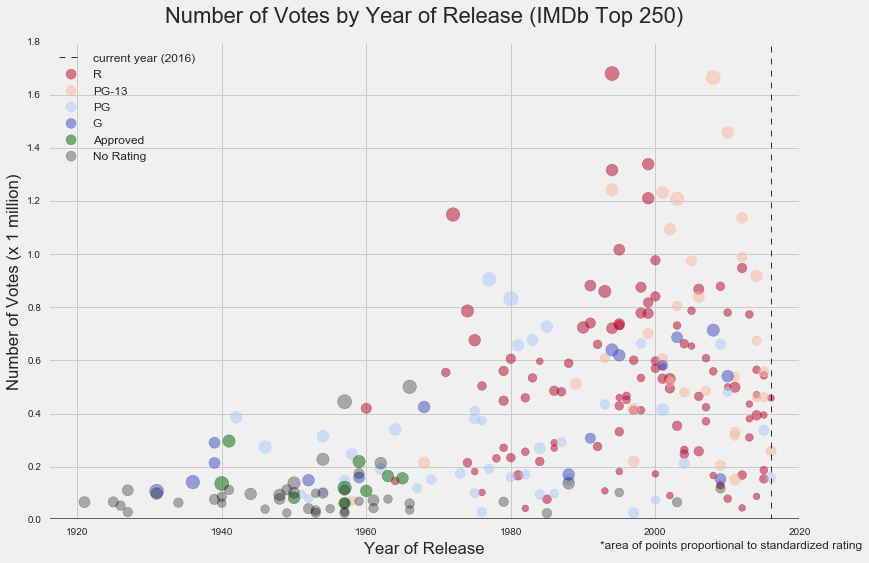

In [43]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# subset dataframe by certification
top_R = top[top['cert'] == 'R']
top_NR = top[top['cert'] == 'Not Rated']
top_PG = top[top['cert'] == 'PG']
top_PG13 = top[top['cert'] == 'PG-13']
top_G = top[top['cert'] == 'G']
top_Approved = top[top['cert'] == 'Approved']

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))

# set area of dot proportional-ish to rating
area = (top_scaled['rating'] + 1.4)*35

# plot number of votes by year of release
plt.scatter(top_R['year'], top_R['num_votes']/1000000, color = cert_dict['R'], alpha = 0.5, s = area, label = 'R')
plt.scatter(top_PG13['year'], top_PG13['num_votes']/1000000, color = cert_dict['PG-13'], alpha = 0.5, s = area, \
            label = 'PG-13')
plt.scatter(top_PG['year'], top_PG['num_votes']/1000000, color = cert_dict['PG'], alpha = 0.5, s = area, label = 'PG')
plt.scatter(top_G['year'], top_G['num_votes']/1000000, color = cert_dict['G'], alpha = 0.5, s = area, label = 'G')
plt.scatter(top_Approved['year'], top_Approved['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'Approved')
plt.scatter(top_NR['year'], top_NR['num_votes']/1000000, color = 'black', alpha = 0.3, s = area, label = 'No Rating')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 1.8])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*area of points proportional to standardized rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

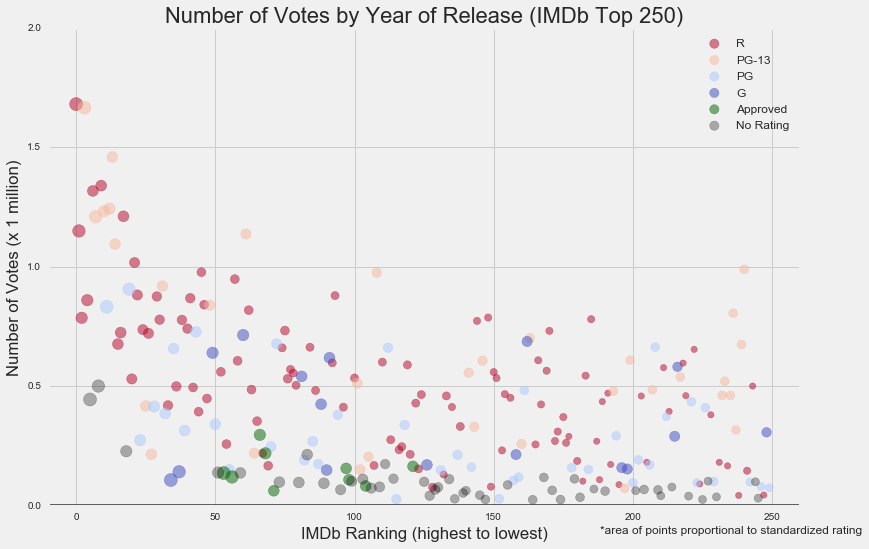

In [44]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# subset dataframe by certification
top_R = top[top['cert'] == 'R']
top_NR = top[top['cert'] == 'Not Rated']
top_PG = top[top['cert'] == 'PG']
top_PG13 = top[top['cert'] == 'PG-13']
top_G = top[top['cert'] == 'G']
top_Approved = top[top['cert'] == 'Approved']

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))

# set area of dot proportional-ish to rating
area = (top_scaled['rating'] + 1.4)*30

# plot number of votes by year of release
plt.scatter(top_R.index, top_R['num_votes']/1000000, color = cert_dict['R'], alpha = 0.5, s = area, label = 'R')
plt.scatter(top_PG13.index, top_PG13['num_votes']/1000000, color = cert_dict['PG-13'], alpha = 0.5, s = area, \
            label = 'PG-13')
plt.scatter(top_PG.index, top_PG['num_votes']/1000000, color = cert_dict['PG'], alpha = 0.5, s = area, label = 'PG')
plt.scatter(top_G.index, top_G['num_votes']/1000000, color = cert_dict['G'], alpha = 0.5, s = area, label = 'G')
plt.scatter(top_Approved.index, top_Approved['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'Approved')
plt.scatter(top_NR.index, top_NR['num_votes']/1000000, color = 'black', alpha = 0.3, s = area, label = 'No Rating')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('IMDb Ranking (highest to lowest)')

# set the figure boundaries
plt.xlim(-10, 260)
plt.ylim([0, 2.0])

plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('*area of points proportional to standardized rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

OK!  Now let's scrape some additional data:

In [45]:
# URL = 'http://www.imdb.com/title/'
# paths = top['tconst']
# soup = []
# for i in paths:
#     time.sleep(1)
#     request = requests.get(URL + i + '/')
#     if str(request) != '<Response [200]>':
#         print URL + i + '/'
#     tiny_soup = BeautifulSoup(request.content, "lxml")
#     soup.append(tiny_soup)

# print 'done scraping!  pickle time.'
# cPickle.dump(soup, open('movie_soup2.p', 'wb')) 

HERE IS THE SOUP!  Not necessary to run the cell because scraped and constructed columns can also be loaded individually below.

In [46]:
# soup = cPickle.load(open('/Users/Rebecca/DSI-projects/projects/project-06/assets/movie_soup2.p', 'rb'))

In [47]:
# running_time = []
# for i in range(len(soup)):
#     times = []
#     for j in soup[i].find_all('time', itemprop = 'duration'):
#         times.append(j.text.encode('utf8'))
#     running_time.append(times[0])

# for i in range(len(running_time)):
#     split_time = []
#     clean_time = running_time[i].replace('\n                        ', '')
#     clean_time = clean_time.replace('min\n                    ', '')
#     split_time = clean_time.split('h ')
#     split_time[0] = split_time[0].replace('h\n                    ', '')
#     if len(split_time) == 1:
#         minutes = float(split_time[0]) * 60
#         running_time[i] = int(minutes) 
#     else:
#         minutes = float(split_time[0]) * 60 + float(split_time[1])
#         running_time[i] = int(minutes)
        
# run_time = pd.DataFrame(running_time, columns = ['run_time'])
# run_time.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv', index = False)

Load running time file and add as column to data frame:

In [48]:
run_time = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv')
top['run_time'] = run_time

In [49]:
# genre = []
# for i in range(len(soup)):
#     genres = []
#     for j in soup[i].find_all('span', itemprop = 'genre'):
#         genres.append(j.text.encode('utf8'))
#     genre.append(genres)

# for i in range(len(genre)):
#     genre[i] = str(genre[i])
    
# genre = pd.DataFrame(genre, columns = ['genre'])
# genre.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv', index = False)

Load genre file and add as column to data frame:

In [50]:
genre = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv')
genre.columns = ['genre']
top['genre'] = genre

In [51]:
# release_info = []
# for i in range(len(soup)):
#     info = []
#     for j in soup[i].find_all('a', title = 'See more release dates'):
#         info.append(j.text.encode('utf8'))
#     release_info.append(info)

# month = []
# country = []
# for i in range(len(release_info)):
#     month_country = []
#     release_info[i] = str(release_info[i])
#     clean = release_info[i].replace(')\\n\\n\']', '')
#     split = clean.split(' ')
#     if len(split) == 4:
#         month.append(split[1])
#         split[3] = split[3].replace('(', '')
#         country.append(split[3])
#     else:
#         month.append(split)
#         country.append(split)

# all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
#              'November', 'December']

# top['month'] = month
# top['country'] = country
# for i in range(len(top)):
#     if top['month'][i] in all_months:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'month', 'country']]
#         print '\n'

Correct the ones that came through in different format and look up month for 'The Gold Rush' (thanks, Wikipedia!):

In [52]:
# top['month'][5] = 'April'
# top['country'][5] = 'USA'
# top['month'][56] = 'October'
# top['country'][56] = 'West Germany'
# top['month'][65] = 'November'
# top['country'][65] = 'South Korea'
# top['month'][129] = 'June'
# top['country'][129] = 'Germany'
# top['month'][209] = 'May'
# top['country'][209] = 'South Korea'
# top['month'][224] = 'December'
# top['country'][224] = 'Hong Kong'

In [53]:
# month = pd.DataFrame(top['month'], columns = ['month'])
# country = pd.DataFrame(top['country'], columns = ['country'])
# month.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv', index = False, encoding = 'utf-8')
# country.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv', index = False, encoding = 'utf-8')

Load month and country files and add as columns to data frame:

In [54]:
month = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv')
country = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv')
top['month'] = month
top['country'] = country
top['month'].value_counts()

December     29
February     24
June         23
March        23
January      21
October      21
May          20
November     20
August       19
July         18
September    17
April        15
Name: month, dtype: int64

Hey, I know!  Let's practice using dictionaries.  We'll make a bar plot of movie counts by month and put the bars in order of month (not in order of count):

In [55]:
y = pd.DataFrame(top['month'].value_counts())
y.columns = ['count']
y['month'] = y.index
y = y.reset_index(drop = True)
order = range(12)
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
              'November', 'December']
month_dict = dict(zip(all_months, order))
y['order'] = y['month'].apply(lambda x: month_dict[x])
y = y.sort('order')
del y['order']
y = y.set_index(y['month'], drop = False)
del y['month']

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



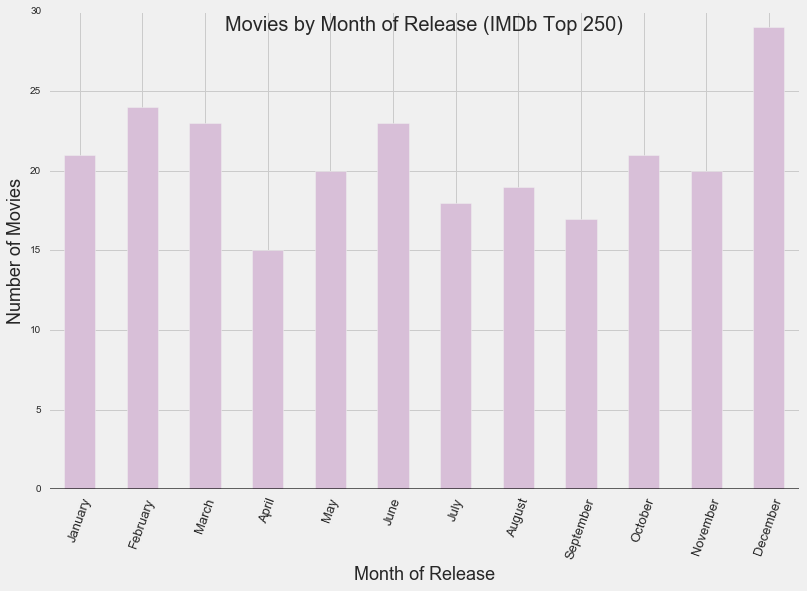

In [56]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y['count'].plot.bar(color = 'thistle')

plt.title('Movies by Month of Release (IMDb Top 250)', fontsize = 20, y = 0.95)

# y label
plt.ylabel('Number of Movies', fontsize = 18)

# x label
plt.xlabel('Month of Release', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

Let's check out where non-USA, non-UK movies are from:

In [57]:
top[(top['country'] != 'USA') & (top['country'] != 'UK')][['title', 'country']].sort('country')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,country
220,The Best Years of Our Lives,Argentina
195,Wild Tales,Argentina
168,Mary and Max,Australia
51,Sunset Blvd.,Australia
70,Vertigo,Brazil
234,Ip Man,China
107,The Hunt,Denmark
149,Incendies,France
152,The Message,France
98,The Apartment,France


A lot of these look weird... Hitchcock in Japan and Brazil?  Reservoir Dogs in France?  Maybe they're release locations?  Let's try to scrape country of origin separately and keep this as-is for now.

In [58]:
# origin = []
# for i in range(len(soup)):
#     country = []
#     for j in soup[i].find_all('a', href = re.compile('/country/')):
#         country.append(j.text.encode('utf8'))
#     if len(country) > 1:
#         mini_list = []
#         mini_list.append(country[0])
#         origin.append(mini_list)
#     else:
#         origin.append(country)

# origin = pd.DataFrame(origin)
# origin.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv', index = False)

Load country of origin (we hope?) file and add as column to the data frame:

In [59]:
origin = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv')
top['origin'] = origin

Let's print all observations where 'country' does not match 'origin':

In [60]:
for i in range(len(top)):
    if top['country'][i] != top['origin'][i]:
        print top.loc[i][['title', 'country', 'origin']]
        print '\n'

title      The Good, the Bad and the Ugly
country                               USA
origin                              Italy
Name: 8, dtype: object


title      The Lord of the Rings: The Fellowship of the Ring
country                                                  USA
origin                                           New Zealand
Name: 10, dtype: object


title      Seven Samurai
country              USA
origin             Japan
Name: 18, dtype: object


title      City of God
country            USA
origin          Brazil
Name: 20, dtype: object


title      Life Is Beautiful
country                  USA
origin                 Italy
Name: 25, dtype: object


title      Léon: The Professional
country                       USA
origin                     France
Name: 26, dtype: object


title      Once Upon a Time in the West
country                             USA
origin                            Italy
Name: 27, dtype: object


title      Spirited Away
country              USA
origin 

Correct these manually (annoying, but at least we don't have to check all of them):

In [61]:
# top['country'][206] = 'UK'
# top['country'][214] = 'Italy'
# top['country'][220] = 'USA'
# top['country'][225] = 'UK'
# top['country'][227] = 'France'
# top['country'][229] = 'USA'
# top['country'][230] = 'Italy'
# top['country'][234] = 'Hong Kong'
# top['country'][241] = 'Italy'
# top['country'][243] = 'UK'
# top['country'][245] = 'Japan'
# top['country'][247] = 'India'
# top['country'][249] = 'Hong Kong'
# top['country'][139] = 'USA'
# top['country'][140] = 'Sweden'
# top['country'][145] = 'USA'
# top['country'][147] = 'Japan'
# top['country'][149] = 'Canada'
# top['country'][152] = 'Lebanon'
# top['country'][154] = 'UK'
# top['country'][164] = 'Russia' # SOVIET UNION!
# top['country'][172] = 'UK'
# top['country'][181] = 'France' # and italy!
# top['country'][186] = 'France'
# top['country'][188] = 'Ireland'
# top['country'][190] = 'Sweden'
# top['country'][192] = 'Mexico'
# top['country'][196] = 'USA'
# top['country'][197] = 'USA'
# top['country'][204] = 'Russia' # SOVIET UNION!
# top['country'][104] = 'USA'
# top['country'][106] = 'Japan'
# top['country'][111] = 'USA'
# top['country'][115] = 'Iran'
# top['country'][117] = 'Germany'
# top['country'][123] = 'Ireland'
# top['country'][124] = 'Spanish'
# top['country'][127] = 'Japan'
# top['country'][129] = 'USA'
# top['country'][134] = 'Sweden'
# top['country'][137] = 'Japan'
# top['country'][70] = 'USA'
# top['country'][73] = 'Germany'
# top['country'][74] = 'USA'
# top['country'][76] = 'France'
# top['country'][87] = 'USA'
# top['country'][89] = 'Italy'
# top['country'][92] = 'UK'
# top['country'][97] = 'Italy'
# top['country'][98] = 'USA'
# top['country'][99] = 'Japan'
# top['country'][103] = 'Germany'
# top['country'][8] = 'Italy'
# top['country'][18] = 'Japan'
# top['country'][20] = 'Brazil'
# top['country'][25] = 'Italy'
# top['country'][26] = 'France'
# top['country'][27] = 'Italy'
# top['country'][28] = 'Japan'
# top['country'][39] = 'USA'
# top['country'][42] = 'France'
# top['country'][44] = 'USA'
# top['country'][51] = 'USA'
# top['country'][54] = 'Germany'
# top['country'][55] = 'Italy'
# top['country'][56] = 'USA'
# top['country'][68] = 'USA'
# top['country'][69] = 'Germany' # WEST Germany!

We've made changes, so save the working version of 'country':

In [62]:
# country = pd.DataFrame(top['country'])
# country.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country2.csv', index = False, \
#                encoding = 'utf-8')

In [63]:
country = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country2.csv')
top['country'] = country

In [65]:
del top['origin']
del top['top_year_color']

Get director name (only take first if more than one):

In [66]:
# director = []
# for i in range(len(soup)):
#     dirs = []
#     for j in soup[i].find_all('span', itemprop = 'director'):
#         for k in j.find_all('span', itemprop = 'name'):
#             dirs.append(k.text.encode('utf8'))
# # these two lines will print all directors' names for movies with more than one director listed
# #            if len(dirs) != 1:
# #                print dirs
#     if len(dirs) > 1:
#         mini_list = []
#         mini_list.append(dirs[0])
#         director.append(mini_list)
#     else:
#         director.append(dirs)
        
# len(director)

In [67]:
# director = pd.DataFrame(director)
# director.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv', index = False)

In [68]:
director = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv')
top['director'] = director

Who directed the Italian movies?

In [69]:
top[top['country'] == 'Italy'][['title', 'year', 'director']].sort('year', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,director
25,Life Is Beautiful,1997,Roberto Benigni
55,Cinema Paradiso,1988,Giuseppe Tornatore
27,Once Upon a Time in the West,1968,Sergio Leone
8,"The Good, the Bad and the Ugly",1966,Sergio Leone
230,The Battle of Algiers,1966,Gillo Pontecorvo
97,For a Few Dollars More,1965,Sergio Leone
241,A Fistful of Dollars,1964,Sergio Leone
214,8½,1963,Federico Fellini
174,Nights of Cabiria,1957,Federico Fellini
89,Bicycle Thieves,1948,Vittorio De Sica


Surprise!  There are no female directors with more than two movies in the Top 250 list:

In [70]:
dir_count = pd.DataFrame(top['director'].value_counts())
dir_count.columns = ['count']
dir_count = dir_count[dir_count['count'] > 2]
dir_count

,count
Stanley Kubrick,7
Steven Spielberg,7
Alfred Hitchcock,7
Christopher Nolan,7
Martin Scorsese,7
Akira Kurosawa,6
Hayao Miyazaki,6
Sergio Leone,5
Charles Chaplin,5
Billy Wilder,5


We'll make dummy variables for these prolific directors later.

## Foreign vs Domestic:

From the colored scatter plot, we can tell there is definitely something going on with 'Not Rated' and 'Approved' MPAA certifications with respect to year of release.  Let's investigate.

In [71]:
foreign_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] != 'USA')]

foreign_NR = top[(top['cert'] == 'Not Rated') & (top['country'] != 'USA')]

domestic_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] == 'USA')]

domestic_NR = top[(top['cert'] == 'Not Rated') & (top['country'] == 'USA')]

Most 'Not Rated' and 'Approved' movies in the list are pre-1970; after 1970, almost all of the 'Not Rated' movies are non-USA.  

In [72]:
x = float(len(foreign_notNR))/ (len(foreign_notNR) + len(foreign_NR))

print 'Proportion of non-\'Not Rated\' foreign films to \'Not Rated\' foreign films post-1970: %s' %round(x, 3)

Proportion of non-'Not Rated' foreign films to 'Not Rated' foreign films post-1970: 0.644


Additionally, all domestic films since 1970 are non-'Not Rated':

In [73]:
y = float(len(domestic_notNR[domestic_notNR['year'] > 1970]))/len(top[(top['country'] == 'USA') & (top['year'] > 1970)])

print 'Proportion of non-\'Not Rated\' domestic films to \'Not Rated\' domestic films post-1970: %s' %round(y, 3)

Proportion of non-'Not Rated' domestic films to 'Not Rated' domestic films post-1970: 1.0


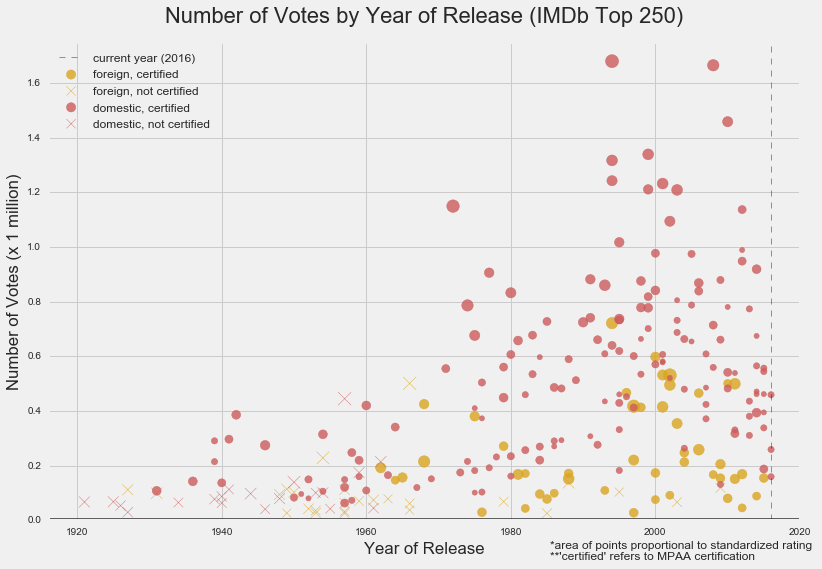

In [74]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


# set area of dot proportional-ish to rating
area = (top_scaled['rating'] + 1.4)*30

# plot number of votes by year of release
plt.scatter(foreign_notNR['year'], foreign_notNR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'o', alpha = 0.8, \
            s = area, \
            label = 'foreign, certified')
plt.scatter(foreign_NR['year'], foreign_NR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'x', alpha = 0.8, \
            s = area, \
            label = 'foreign, not certified')
plt.scatter(domestic_notNR['year'], domestic_notNR['num_votes']/1000000, color = 'IndianRed', \
            marker = 'o', alpha = 0.8, \
            s = area, \
            label = 'domestic, certified')
plt.scatter(domestic_NR['year'], domestic_NR['num_votes']/1000000, color = 'IndianRed', \
            marker = 'x', alpha = 0.8, \
            s = area, \
            label = 'domestic, not certified')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, alpha = 0.5, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 1.75])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*area of points proportional to standardized rating \n**\'certified\' refers to MPAA certification', \
                (1,0), (-250, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

What is the most recently released USA movie that had no MPAA rating ('cert')?

In [75]:
domestic_NR[['title', 'year']].sort('year', ascending = False).head(1)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
83,To Kill a Mockingbird,1962


What's the highest-rated foreign movie?

In [76]:
top[top['country'] != 'USA'].sort('num_votes', ascending = False).head(1)[['title', 'year', 'country']]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,country
26,Léon: The Professional,1994,France


Since the most recent 'Not Rated' domestic movie was 1962, let's see which foreign movies have been 'Not Rated' since then:

In [77]:
top[(top['country'] != 'USA') & (top['cert'] == 'Not Rated') & (top['year'] > 1962)].sort('year', \
                                                    ascending = False).sort('year', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,tconst,title,rating,num_votes,year,cert,run_time,genre,month,country,director
168,tt0978762,Mary and Max,8.2,118420,2009,Not Rated,92,"['Animation', 'Comedy', 'Drama']",April,Australia,Adam Elliot
209,tt0353969,Memories of Murder,8.1,66197,2003,Not Rated,132,"['Crime', 'Drama', 'Mystery']",May,South Korea,Joon-ho Bong
227,tt0113247,La Haine,8.1,102825,1995,Not Rated,98,"['Crime', 'Drama']",February,France,Mathieu Kassovitz
59,tt0095327,Grave of the Fireflies,8.5,137176,1988,Not Rated,89,"['Animation', 'Drama', 'War']",April,Japan,Isao Takahata
164,tt0091251,Come and See,8.3,25099,1985,Not Rated,140,"['Drama', 'War']",October,Russia,Elem Klimov
204,tt0079944,Stalker,8.1,67948,1979,Not Rated,163,"['Drama', 'Mystery', 'Sci-Fi']",April,Russia,Andrei Tarkovsky
8,tt0060196,"The Good, the Bad and the Ugly",8.9,500638,1966,Not Rated,161,['Western'],December,Italy,Sergio Leone
190,tt0060827,Persona,8.1,61168,1966,Not Rated,83,"['Drama', 'Thriller']",March,Sweden,Ingmar Bergman
230,tt0058946,The Battle of Algiers,8.1,36969,1966,Not Rated,121,"['Drama', 'War']",September,Italy,Gillo Pontecorvo
214,tt0056801,8½,8.1,78138,1963,Not Rated,138,"['Drama', 'Fantasy']",June,Italy,Federico Fellini


## Time to make dummies:

In [78]:
cv = CountVectorizer()
data = cv.fit_transform(top['genre']).todense()
columns = [c for c in cv.get_feature_names()]
dumbgenre = pd.DataFrame(data, columns=columns)

In [79]:
dumbgenre.columns

Index([u'action', u'adventure', u'animation', u'biography', u'comedy',
       u'crime', u'drama', u'family', u'fantasy', u'fi', u'film', u'history',
       u'horror', u'music', u'musical', u'mystery', u'noir', u'romance',
       u'sci', u'sport', u'thriller', u'war', u'western'],
      dtype='object')

Looks like strings 'sci fi' and 'film noir' got split up into separate dummy columns; let's delete one from each word pair so as not to be redundant in our columns:

In [80]:
del dumbgenre['fi']
del dumbgenre['film']
dumbgenre['scifi'] = dumbgenre['sci']
del dumbgenre['sci']

In [81]:
for column in dumbgenre.columns:
    x = dumbgenre[column].sum()
    print column, x

action 39
adventure 64
animation 19
biography 25
comedy 40
crime 55
drama 171
family 13
fantasy 20
history 14
horror 6
music 1
musical 1
mystery 30
noir 8
romance 21
sport 4
thriller 37
war 19
western 8
scifi 25


Should we consolidate music genre with musical genre?  There's only one movie in each genre in the top 250, so maybe we can...

In [82]:
dumbgenre[dumbgenre['music'] == 1]

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,...,music,musical,mystery,noir,romance,sport,thriller,war,western,scifi
44,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [83]:
top.loc[44]['title']

'Whiplash'

In [84]:
dumbgenre[dumbgenre['musical'] == 1]

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,...,music,musical,mystery,noir,romance,sport,thriller,war,western,scifi
90,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [85]:
top.loc[90]['title']

"Singin' in the Rain"

'Whiplash' and 'Singin in the Rain'?  Nope, looks like we won't consolidate those two... on to more dummies!

In [86]:
dumbmonth = top[['month']]
dumbmonth = pd.get_dummies(dumbmonth)
dumbmonth.head(1)

,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [87]:
dumbmonth = top[['month']]
dumbmonth = pd.get_dummies(dumbmonth)
dumbmonth.head(1)

,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:
big_directors = dir_count.index
big_dir = []
for i in range(len(top['director'])):
    if top['director'][i] in big_directors:
        big_dir.append(top['director'][i])
    else:
        big_dir.append(0)
        
big_dir = pd.DataFrame(big_dir)
top['big_dir'] = big_dir

In [89]:
dumbdir = top[['big_dir']]
dumbdir = pd.get_dummies(dumbdir)
dumbdir.head(1)

,big_dir_0,big_dir_Akira Kurosawa,big_dir_Alfred Hitchcock,big_dir_Billy Wilder,big_dir_Charles Chaplin,big_dir_Christopher Nolan,big_dir_Clint Eastwood,big_dir_David Fincher,big_dir_Francis Ford Coppola,big_dir_Frank Capra,...,big_dir_Martin Scorsese,big_dir_Pete Docter,big_dir_Peter Jackson,big_dir_Quentin Tarantino,big_dir_Ridley Scott,big_dir_Sergio Leone,big_dir_Sidney Lumet,big_dir_Stanley Kubrick,big_dir_Steven Spielberg,big_dir_William Wyler
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
del dumbdir['big_dir_0']
del top['big_dir']

In [91]:
country_count = pd.DataFrame(top['country'].value_counts())
country_count.columns = ['count']
country_count = country_count[country_count['count'] > 2]
country_count

,count
USA,177
Japan,14
UK,12
Italy,10
France,7
Germany,5
Sweden,4
Hong Kong,3


In [92]:
big_country = country_count.index
big_countries = []
for i in range(len(top['country'])):
    if top['country'][i] in big_country:
        big_countries.append(top['country'][i])
    else:
        big_countries.append(0)
        
big_countries = pd.DataFrame(big_countries)
top['big_countries'] = big_countries

In [93]:
dumbcountry = top[['big_countries']]
dumbcountry = pd.get_dummies(dumbcountry)
dumbcountry.head(1)

,big_countries_0,big_countries_France,big_countries_Germany,big_countries_Hong Kong,big_countries_Italy,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [94]:
del dumbcountry['big_countries_0']

In [95]:
dumbcert = top[['cert']]
dumbcert = pd.get_dummies(dumbcert)
dumbcert.head(1)

,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,0.0,0.0,0.0,0.0,0.0,1.0


In [96]:
big_top = pd.concat([top, dumbgenre, dumbmonth, dumbdir, dumbcountry, dumbcert], axis = 1)
big_top.head(1)

,tconst,title,rating,num_votes,year,cert,run_time,genre,month,country,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,tt0111161,The Shawshank Redemption,9.3,1680129,1994,R,142,"['Crime', 'Drama']",October,USA,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [97]:
del big_top['tconst']
del big_top['title']
del big_top['cert']
del big_top['month']
del big_top['country']
del big_top['genre']
del big_top['director']
del big_top['big_countries']

In [98]:
big_top.head(2)

,rating,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,9.3,1680129,1994,142,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.2,1149482,1972,175,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


No columns should sum to zero, but let's check:

In [99]:
for i in big_top.columns:
    if big_top[i].sum() == 0:
        print '\n'
        print i
        print big_top[i].sum() 
    else:
        print '.',
        continue

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


## Let's plot!

In [100]:
len(big_top.columns)

73

In [150]:
X = pd.DataFrame(big_top.ix[:, 1:len(big_top.columns)], columns = big_top.columns[1:len(big_top.columns)])
X_scaled = MinMaxScaler().fit_transform(X.astype(float))
X_scaled = pd.DataFrame(X_scaled, columns = X.columns[0:len(big_top.columns)])
len(X_scaled.columns)

72

In [151]:
y = big_top.ix[:, 0]

In [104]:
X_corr = pd.DataFrame(np.corrcoef(X_scaled.values.T), columns = X_scaled.columns)
X_corr.corr()

,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,drama,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
num_votes,1.000000,0.773260,0.405300,0.637947,0.355566,-0.088743,0.057953,-0.254841,0.111299,-0.253506,...,-0.359354,-0.269669,-0.179778,0.606428,-0.268780,-0.127139,-0.730502,-0.184319,0.594065,0.437458
year,0.773260,1.000000,0.359512,0.453962,0.287320,0.119388,0.287449,-0.288798,-0.006279,-0.159944,...,-0.161566,-0.215138,-0.049062,0.233591,-0.397220,-0.116740,-0.799301,-0.108461,0.476442,0.546840
run_time,0.405300,0.359512,1.000000,0.335207,-0.003511,-0.428509,0.424018,-0.543674,0.116905,0.358999,...,-0.184159,-0.122407,-0.109858,0.129793,-0.054327,-0.369422,-0.332522,-0.266032,0.337447,0.380430
action,0.637947,0.453962,0.335207,1.000000,0.605238,-0.036776,-0.111226,-0.217593,-0.209335,-0.457734,...,-0.074168,-0.157529,-0.174202,0.336452,-0.123895,-0.151367,-0.407329,-0.013837,0.637699,0.025295
adventure,0.355566,0.287320,-0.003511,0.605238,1.000000,0.578414,-0.207339,0.143973,-0.452609,-0.707615,...,0.214453,-0.167061,-0.010984,0.208113,-0.114482,0.363130,-0.324182,0.448673,0.467946,-0.436153
animation,-0.088743,0.119388,-0.428509,-0.036776,0.578414,1.000000,-0.225677,0.329919,-0.349584,-0.555178,...,0.579830,-0.067911,0.010569,-0.161226,-0.138456,0.634273,-0.072126,0.482366,-0.050229,-0.436328
biography,0.057953,0.287449,0.424018,-0.111226,-0.207339,-0.225677,1.000000,-0.190158,0.110519,0.394495,...,-0.174067,-0.077932,0.158949,-0.053693,-0.123771,-0.192971,-0.254862,-0.017609,-0.049994,0.351421
comedy,-0.254841,-0.288798,-0.543674,-0.217593,0.143973,0.329919,-0.190158,1.000000,-0.104418,-0.344743,...,0.019313,-0.056379,0.245501,-0.023964,0.094417,0.467779,0.199244,0.205072,-0.235179,-0.354241
crime,0.111299,-0.006279,0.116905,-0.209335,-0.452609,-0.349584,0.110519,-0.104418,1.000000,0.320310,...,-0.215597,-0.093703,-0.003097,0.139984,0.027349,-0.316256,0.058973,-0.324679,-0.225773,0.418523
drama,-0.253506,-0.159944,0.358999,-0.457734,-0.707615,-0.555178,0.394495,-0.344743,0.320310,1.000000,...,-0.144082,0.179015,-0.124032,-0.183861,0.103416,-0.376685,0.278201,-0.461173,-0.259993,0.359710


Set up plot parameters:

In [152]:
n = 250
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return   

In [107]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, X_scaled, y, cv=cv)
scores.mean()

0.16800000000000001

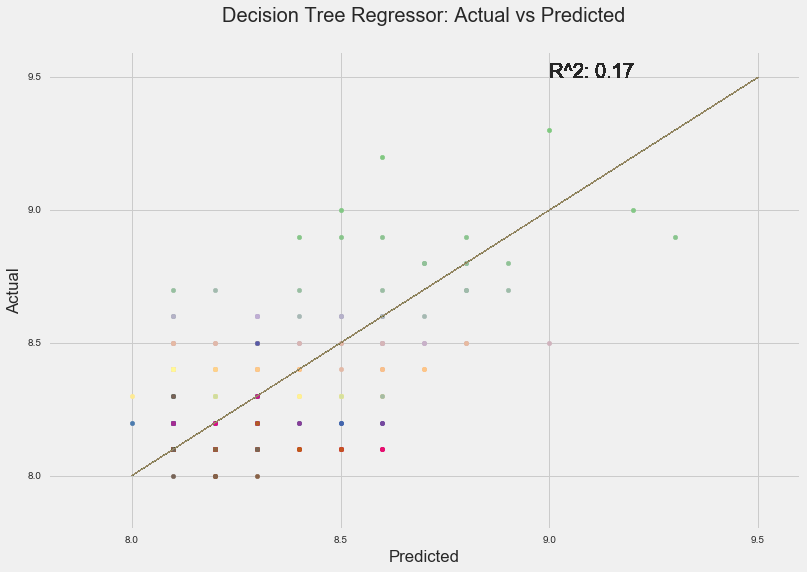

In [108]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(dt, scores.mean().round(2))

In [153]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, X_scaled, y, cv=cv)
scores.mean()

0.0

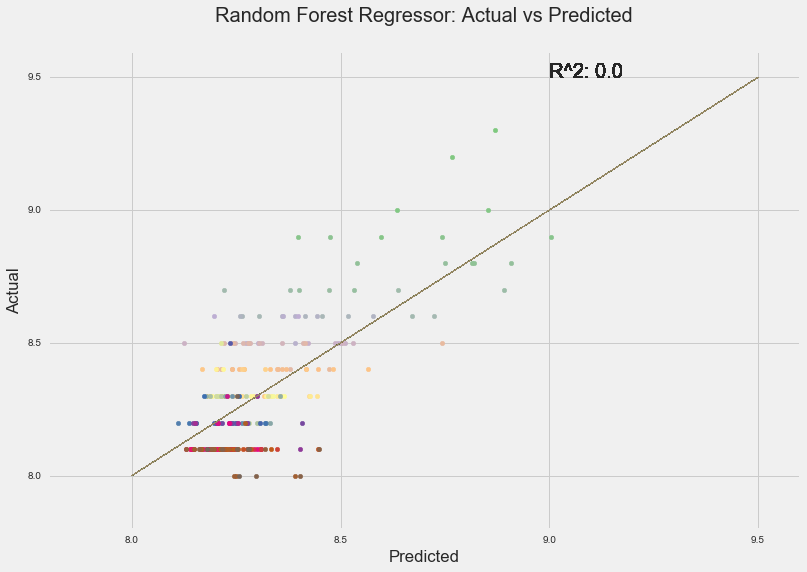

In [154]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

In [315]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, X_scaled, y, cv=cv)
scores.mean()

0.0040000000000000001

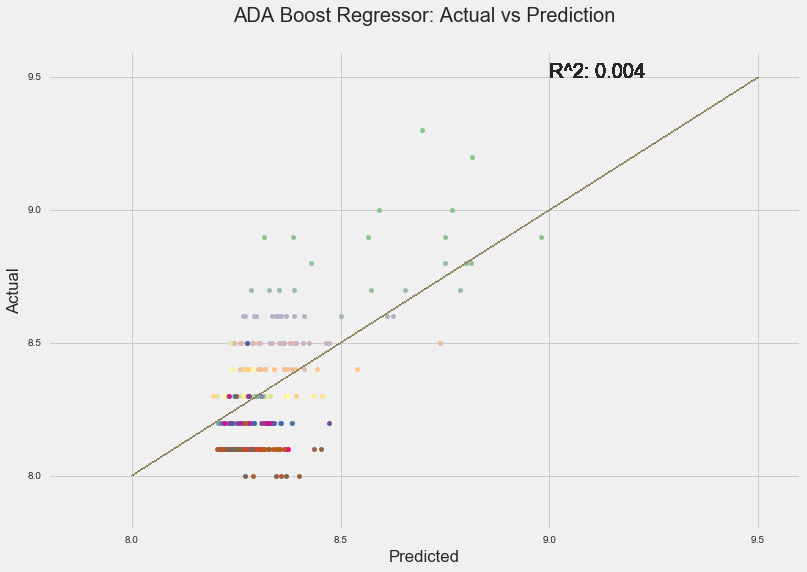

In [317]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ADA Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(3))

In [321]:
gb = GradientBoostingRegressor(n_estimators = 100)

scores = cross_val_score(gb, X_scaled, y, cv=cv)
scores.mean()

0.0

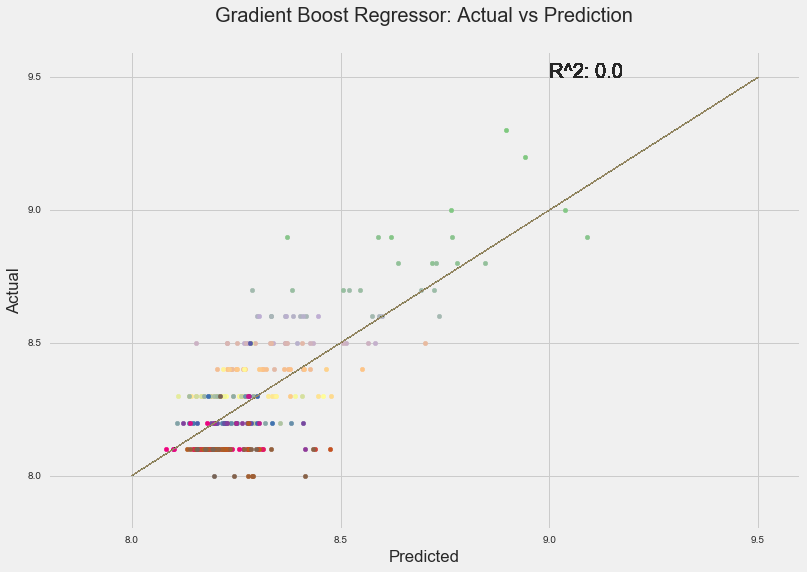

In [322]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(gb, scores.mean().round(2))

In [318]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(et, X_scaled, y, cv=cv)
scores.mean()

0.0

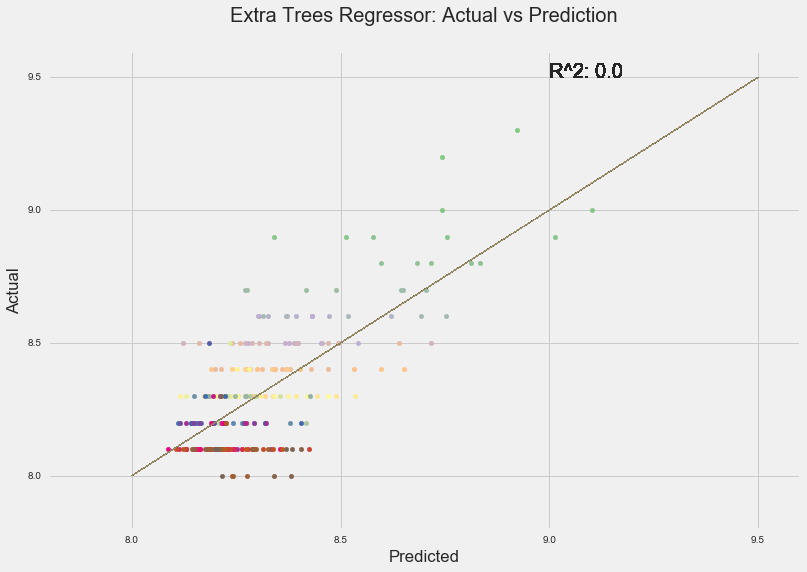

In [319]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(et, scores.mean().round(2))

In [303]:
bagger = BaggingRegressor(DecisionTreeRegressor())

scores = cross_val_score(bagger, X_scaled, y, cv=cv)
scores.mean()

0.016

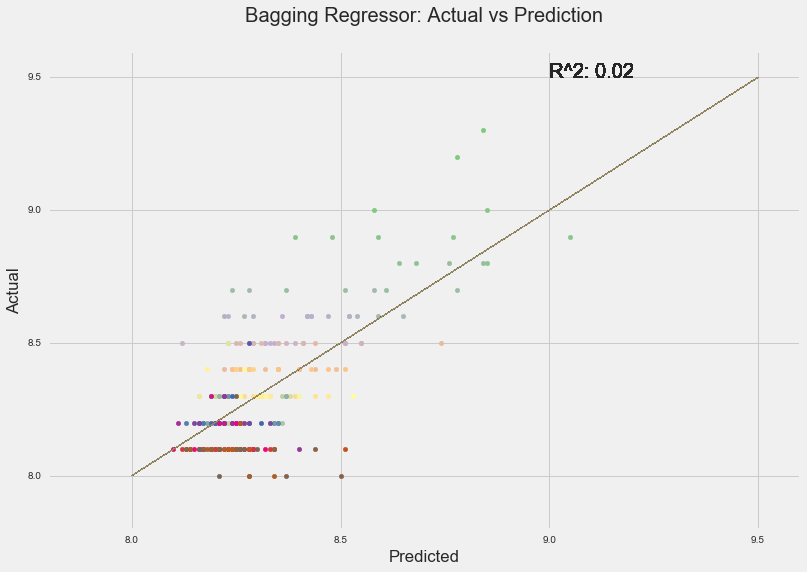

In [305]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bagging Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(bagger, scores.mean().round(2))

In [325]:
def get_score(model, name):
    score = cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1)
    print('{} Score:\t{:0.3} ± {:0.3}'.format(name, score.mean().round(3), score.std().round(3)))
    
pairs = {
    'Decision Tree' : dt,
    'Bagging' : bagger,
    'Random Forest' : rf,
    'Extra Trees' : et,
    'Ada Booster' : ab,
    'Gradient Booster' : gb
}

for key in list(pairs.keys()):
    get_score(pairs[key], key)

Bagging Score:	0.016 ± 0.125
Extra Trees Score:	0.0 ± 0.0
Decision Tree Score:	0.176 ± 0.381
Gradient Booster Score:	0.0 ± 0.0
Ada Booster Score:	0.008 ± 0.089
Random Forest Score:	0.0 ± 0.0


We'll stick with random forest for now. 

In [155]:
rf.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), Xs.columns), 
             reverse=True)


Features sorted by their score:
[(0.516, 'num_votes'), (0.1494, 'year'), (0.0693, 'run_time'), (0.0129, u'crime'), (0.0111, 'big_countries_Italy'), (0.0102, 'big_dir_Hayao Miyazaki'), (0.0088, 'big_countries_Hong Kong'), (0.0082, 'big_dir_Pete Docter'), (0.0075, u'drama'), (0.0072, 'big_countries_USA'), (0.0067, 'cert_Not Rated'), (0.0064, 'month_November'), (0.006, u'action'), (0.0059, u'music'), (0.0057, u'adventure'), (0.005, 'cert_R'), (0.0048, 'month_January'), (0.0047, 'month_March'), (0.0047, 'big_dir_Francis Ford Coppola'), (0.0046, 'month_July'), (0.0044, 'month_September'), (0.0043, 'month_May'), (0.0043, u'comedy'), (0.0042, u'western'), (0.0041, 'cert_Approved'), (0.0038, 'month_December'), (0.0037, 'month_June'), (0.0036, 'scifi'), (0.0036, u'animation'), (0.0035, 'month_August'), (0.0033, 'month_February'), (0.0032, 'big_countries_Japan'), (0.0031, 'big_countries_Sweden'), (0.003, u'biography'), (0.0028, u'history'), (0.0027, u'romance'), (0.0026, 'cert_PG'), (0.0025, 'mo

In [156]:
rf.feature_importances_

array([  5.16033809e-01,   1.49404632e-01,   6.92652648e-02,
         6.01046680e-03,   5.70397268e-03,   3.59297016e-03,
         3.00220342e-03,   4.31114167e-03,   1.29268450e-02,
         7.48585189e-03,   1.90176261e-03,   2.31823910e-03,
         2.80747483e-03,   2.28860088e-03,   5.91177146e-03,
         3.23383729e-04,   2.69263233e-03,   4.76310025e-04,
         2.01843756e-03,   5.46142731e-04,   4.16203256e-03,
         3.64764792e-03,   2.07906446e-03,   3.47947352e-03,
         3.83536686e-03,   3.27180871e-03,   4.81231651e-03,
         4.63559537e-03,   3.69497312e-03,   4.68983386e-03,
         4.33802500e-03,   6.41427555e-03,   2.46496286e-03,
         4.41555007e-03,   2.51711083e-03,   2.31326689e-03,
         1.29556304e-03,   1.45173635e-03,   4.74827516e-03,
         1.02259257e-02,   2.39653396e-03,   3.73012102e-04,
         1.04806534e-05,   8.19813702e-03,   1.00245289e-03,
         6.55932422e-04,   3.47210818e-04,   1.22423572e-04,
         1.09811880e-03,

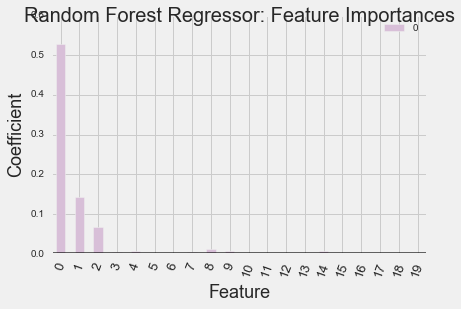

In [120]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

z = pd.DataFrame(rf.feature_importances_[0:20])

z.plot.bar(color = 'thistle')

plt.title('Random Forest Regressor: Feature Importances', fontsize = 20, y = 0.95)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

Let's just do movies since 1962, since right around then seems to have been a turning point in terms of user rating-ness on IMDb:

In [157]:
smaller_top = big_top[big_top['year'] > 1962]
X_new = pd.DataFrame(smaller_top.ix[:, 1:len(smaller_top.columns)], \
                     columns = smaller_top.columns[1:len(smaller_top.columns)])
Xs = MinMaxScaler().fit_transform(X_new.astype(float))
Xs = pd.DataFrame(Xs, columns = X.columns[0:len(smaller_top.columns)])
len(Xs.columns)

72

In [158]:
for i in Xs.columns:
    if Xs[i].sum() == 0:
        print '\n'
        print i
    else:
        print '.',

. . . . . . . . . . . . . . . 

musical
. 

noir
. . . . . . . . . . . . . . . . . . . 

big_dir_Alfred Hitchcock


big_dir_Billy Wilder


big_dir_Charles Chaplin
. . . . 

big_dir_Frank Capra
. . . . . . . . . . . . 

big_dir_William Wyler
. . . . . . . . . . . . . .


In [159]:
del Xs['musical']
del Xs['noir']
del Xs['big_dir_Alfred Hitchcock']
del Xs['big_dir_Billy Wilder']
del Xs['big_dir_Charles Chaplin']
del Xs['big_dir_Frank Capra']
del Xs['big_dir_William Wyler']

In [160]:
y_new = smaller_top.ix[:, 0]

In [161]:
n = len(Xs)
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X_new), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return  

In [144]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, Xs, y_new, cv=cv)
scores.mean()

0.0

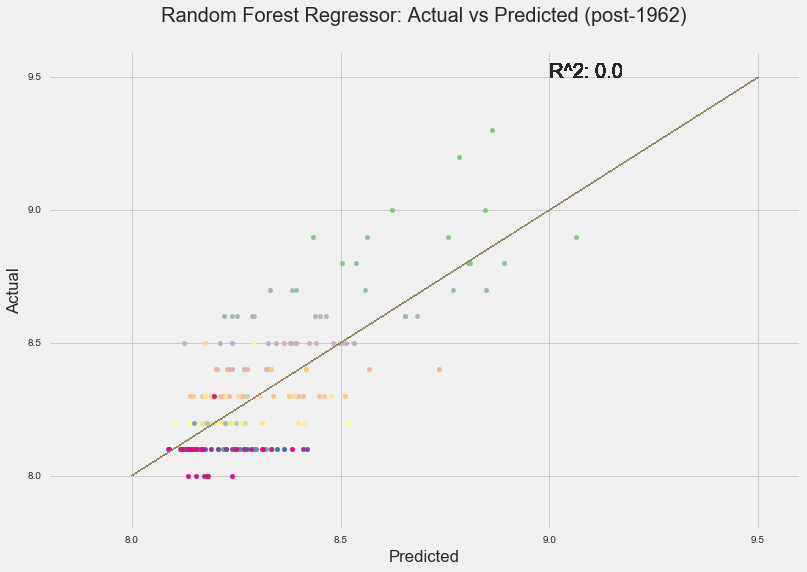

In [145]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

In [147]:
rf.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), Xs.columns), 
             reverse=True)

Features sorted by their score:
[(0.5729, 'num_votes'), (0.1233, 'year'), (0.0638, 'run_time'), (0.0209, 'big_countries_USA'), (0.0142, 'big_countries_Italy'), (0.0139, 'big_dir_Sergio Leone'), (0.0119, 'big_dir_Francis Ford Coppola'), (0.0105, u'crime'), (0.01, 'big_countries_France'), (0.0088, u'drama'), (0.0086, u'music'), (0.008, 'month_July'), (0.0067, 'big_countries_Germany'), (0.0059, 'month_February'), (0.0058, 'cert_PG-13'), (0.0054, 'month_March'), (0.0053, 'big_countries_UK'), (0.0052, 'month_June'), (0.005, u'action'), (0.0048, u'thriller'), (0.0046, u'horror'), (0.0045, 'month_December'), (0.0044, 'cert_R'), (0.0044, u'adventure'), (0.0043, 'big_countries_Japan'), (0.0042, 'month_May'), (0.0037, 'big_dir_Stanley Kubrick'), (0.0036, u'comedy'), (0.0034, u'western'), (0.0032, u'war'), (0.0031, 'month_November'), (0.003, 'scifi'), (0.0027, 'month_August'), (0.0027, 'cert_PG'), (0.0025, 'month_January'), (0.0025, u'biography'), (0.0024, 'month_October'), (0.0024, u'animation')

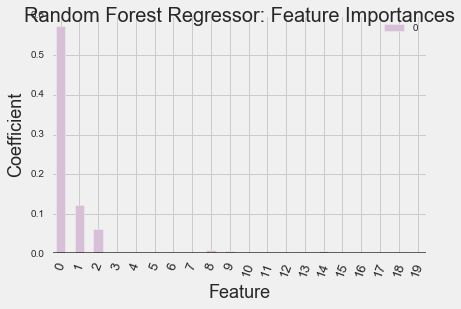

In [148]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

z = pd.DataFrame(rf.feature_importances_[0:20])

z.plot.bar(color = 'thistle')

plt.title('Random Forest Regressor: Feature Importances', fontsize = 20, y = 0.95)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

As we can see from changes in the histograms of feature importance, once we remove pre-1962 movies from the data set, vote count becomes more important, while year becomes less so.  This makes sense intuitively, since we know that older movies have fewer votes on average and the number of votes for newer movies is increasingly spread out.  Refer to the Rating vs Number of Votes plot (blue-to-red dots, by year) to illustrate this point; if you take out all the blue points, the variance in remaining dots becomes larger (i.e., number of votes is an even more significant predictive feature).  Along these same lines, once the older movies are removed, year of release is a less significant feature.

Run time appears to be a significant feature, as well.



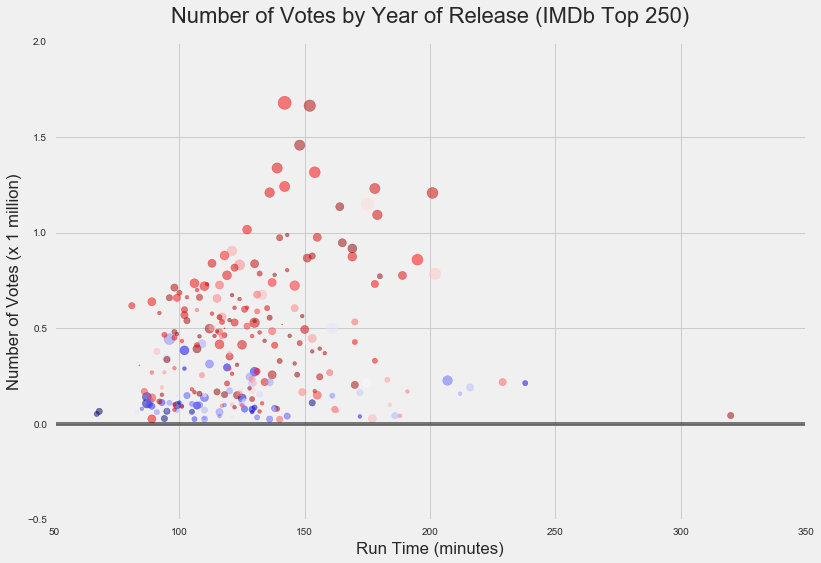

In [169]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
count = 0
for i in top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
top['top_year_color'] = top_year_color

area = (top_scaled['rating'] + 1.4)*30

plt.scatter(top['run_time'], top['num_votes']/1000000, color = top['top_year_color'], alpha = 0.5, s = area)

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)
plt.axhline(0, color='black', alpha = 0.5)

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Run Time (minutes)')

# set the figure boundaries
# plt.xlim([min(top['year'])-5, 2020])
# plt.ylim([0, 2.0])
plt.grid(True)
# plt.annotate('*area of points proportional to normalized rating', (1,0), (-200, -20), \
#             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

In [ ]:
top[top['run_time']]